# Download dataset and import libraries

!kaggle competitions download -c advanced-dls-spring-2021

!unzip advanced-dls-spring-2021.zip -d data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('data/train.csv')
df = train_df.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [4]:
df.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [5]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
df.Churn.value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

Let's convert 'TotalSpent' feature to float64, instead of nan it has ' ' (space).

In [7]:
df['TotalSpent'] = df['TotalSpent'].replace(' ', np.nan).fillna(0)
for col in num_cols:
        df[col] = df[col].astype('float64')

### Let's visualize

Numerical features

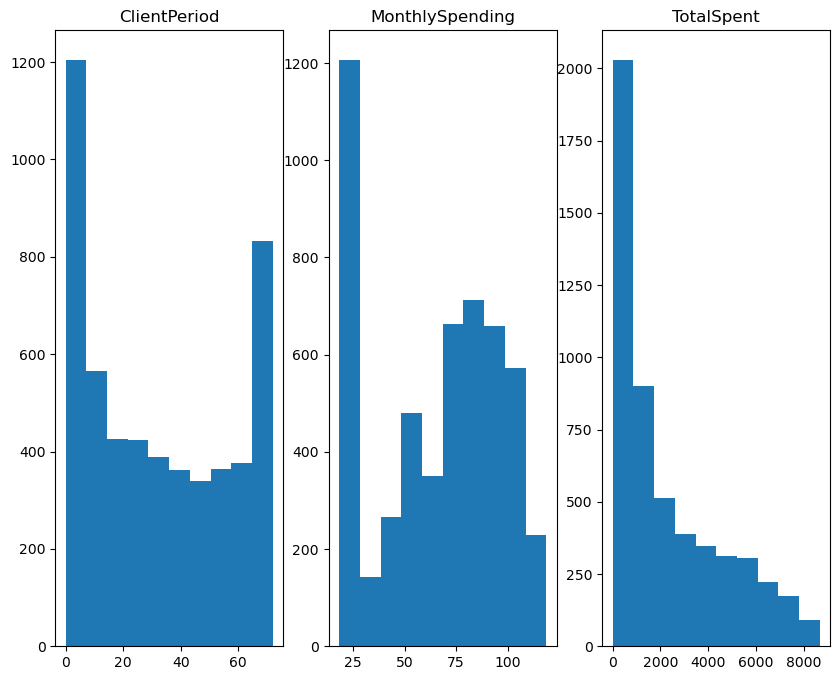

In [8]:
plt.figure(figsize=(10, 8))
for i in range(len(num_cols)):
  plt.subplot(1, len(num_cols), i + 1)
  plt.title(num_cols[i])
  plt.hist(df[num_cols[i]])

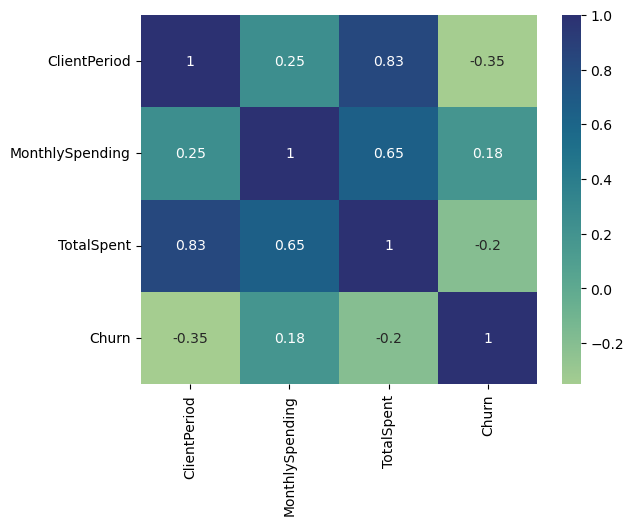

In [9]:
corr = df[num_cols + ['Churn']].corr()
sns.heatmap(corr, cmap='crest', annot=True)
plt.show()

It is obvious that the longer a client uses a company's services, the more significant the total payments become. Therefore, the TotalSpent and ClientPeriod features are strongly correlated with each other.
Additionally, the TotalSpent feature is correlated with MonthlySpending, which is not surprising since the higher the monthly fee, the greater the total number of payments will be.
The strongest correlation with the target variable (Churn) is observed with the ClientPeriod feature.

Categorical features

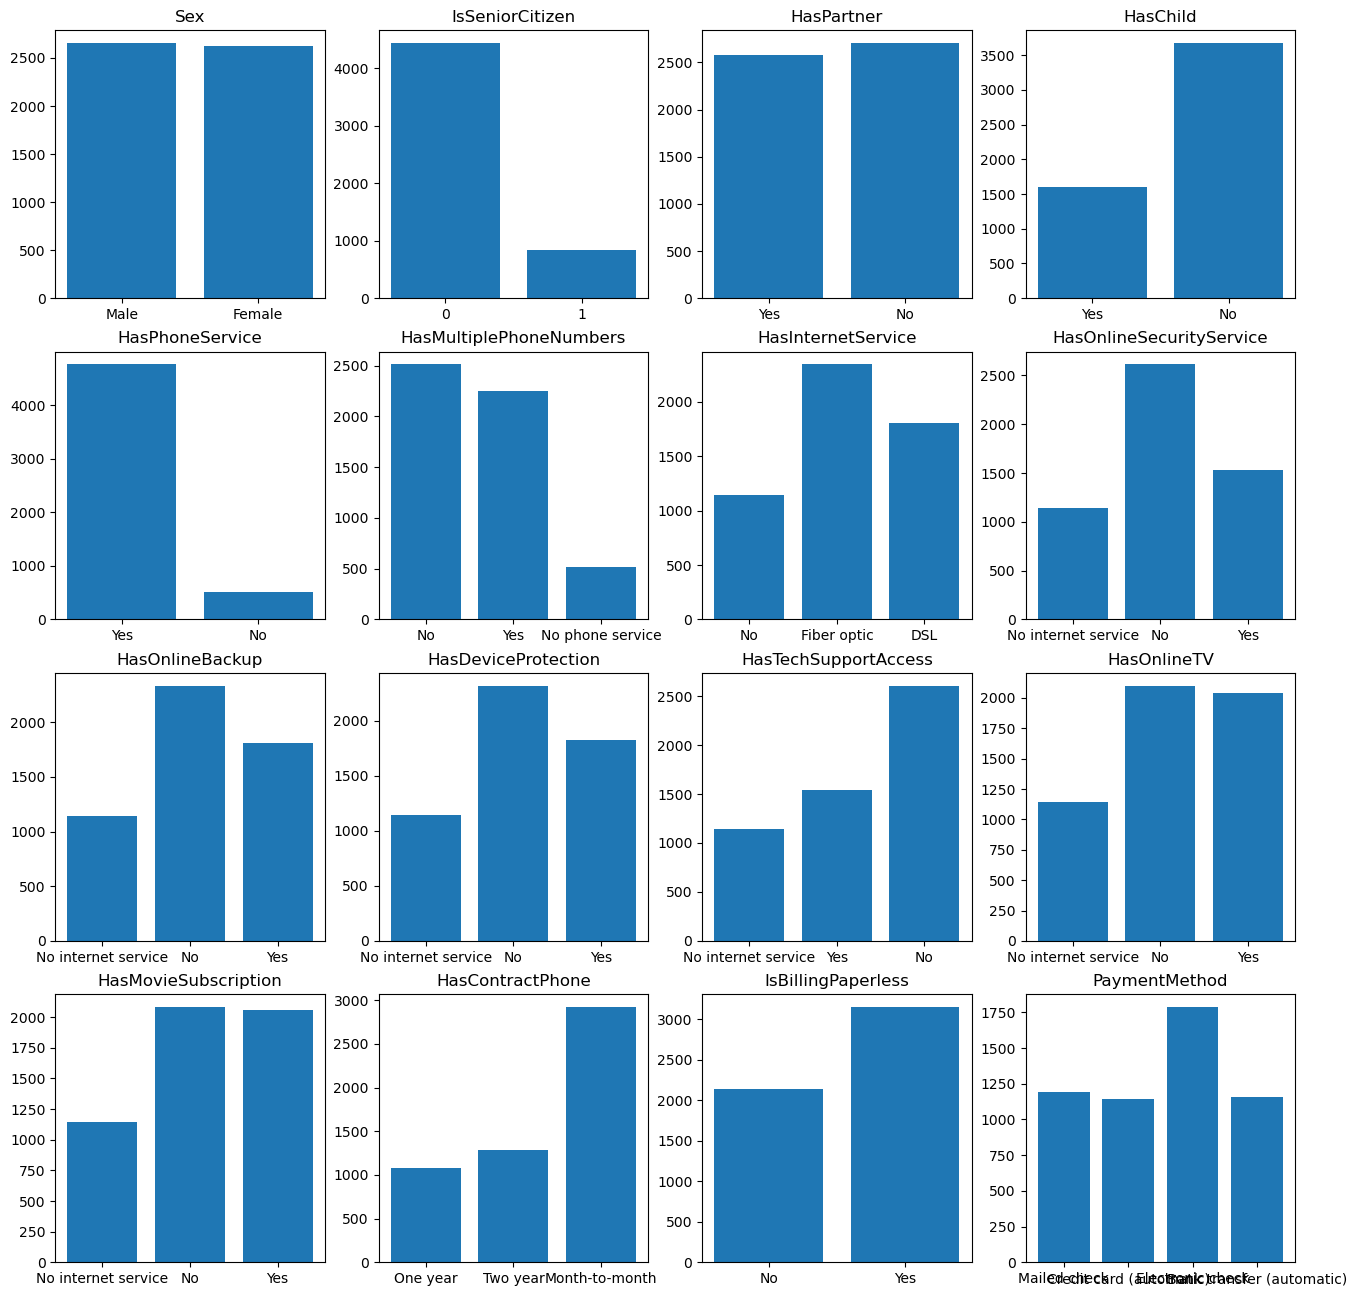

In [10]:
plt.figure(figsize=(16, 16))
n = int(np.ceil(np.sqrt(len(cat_cols))))
for i in range(len(cat_cols)):
  col = cat_cols[i]
  unique = df[col].unique()
  vals = df[col].value_counts(sort=False)
  new_col = pd.DataFrame(vals, index=unique, columns=[col])
  plt.subplot(n, n, i + 1)
  plt.title(col)
  plt.bar(unique.astype(str), vals)
  
plt.show()

In [11]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

num_pipeline = make_pipeline(
  SimpleImputer(strategy='mean'),
  StandardScaler(),   
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

preprocessing = ColumnTransformer(
    [
      ('num', num_pipeline, num_cols),
      ('cat', cat_pipeline, cat_cols)
    ]
)

# Modeling

## Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [13]:
X = df.drop(columns=['Churn'])
y = df.Churn

In [14]:
model = make_pipeline(
    preprocessing,
    LogisticRegression(max_iter=1000),
)

params = [
    {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],}
]

grid_search = GridSearchCV(
    model,
    params,
    scoring='roc_auc',
    n_jobs=-1,
)

grid_search.fit(X, y)
clf_lr = grid_search.best_estimator_

In [15]:
print(f"best score: {grid_search.best_score_}")
print(f"best params: {grid_search.best_params_}")

best score: 0.8451102185255334
best params: {'logisticregression__C': 100}


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'rf__max_depth': np.arange(4, 7, 1),
    'rf__n_estimators': np.arange(50, 150, 50),
    'rf__min_samples_split': np.arange(2, 6, 1),
    'rf__min_samples_leaf': np.arange(1, 25, 5)
}

model = Pipeline([
    ('preprocessing', preprocessing),
    ('rf', RandomForestClassifier())
])

grid_search = GridSearchCV(
    model,
    params,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=True,
)
grid_search.fit(X, y)
clf_rf = grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [17]:
print(f"best score: {grid_search.best_score_}")
print(f"best params: {grid_search.best_params_}")

best score: 0.8454820556388996
best params: {'rf__max_depth': 6, 'rf__min_samples_leaf': 11, 'rf__min_samples_split': 4, 'rf__n_estimators': 100}


# XGBoost

In [18]:
import xgboost as xgb

model = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', xgb.XGBClassifier())
])

params = {
    'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.3],
    'xgb__max_depth': np.arange(4, 10),
    'xgb__min_child_weight': np.arange(0, 5),
    'xgb__n_estimators': np.arange(50, 100, 50)
}

grid_search = GridSearchCV(
    model,
    params,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=True
)
grid_search.fit(X, y)
clf_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [19]:
print(f"best score: {grid_search.best_score_}")
print(f"best params: {grid_search.best_params_}")

best score: 0.8449554360355105
best params: {'xgb__learning_rate': 0.06, 'xgb__max_depth': 4, 'xgb__min_child_weight': 0, 'xgb__n_estimators': 50}


# Catboost

In [20]:
from catboost import CatBoostClassifier

clf_cat = CatBoostClassifier(
    logging_level="Silent",
    cat_features=cat_cols,
    eval_metric='AUC:hints=skip_train~false'
)

params = {
    'learning_rate': [0.01, 0.03, 0.06, 0.1],
    'depth': np.arange(4, 10, 1),
    'n_estimators': np.arange(100, 300, 50),
}

clf_cat.grid_search(
    param_grid=params,
    X=X,
    y=y,
    verbose=False,
)

{'params': {'depth': 5, 'iterations': 200, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [21]:
clf_cat.get_best_score()

{'learn': {'Logloss': 0.3564095419085882, 'AUC': 0.8931311484769127}}

In [22]:
clf_cat.get_params()

{'logging_level': 'Silent',
 'eval_metric': 'AUC:hints=skip_train~false',
 'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'depth': 5,
 'iterations': 200,
 'learning_rate': 0.1}

Let's submit it to the Kaggle and see what we will get

In [23]:
test_df = pd.read_csv('data/test.csv')
pred = clf_cat.predict_proba(test_df)

submission = pd.read_csv('data/submission.csv')
submission['Churn'] = pred[:, 1]
submission.to_csv('catboost_pred.csv', index=False)

got: 0.85298